In [128]:
# -*- coding: utf-8 -*-
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from mca import MCA
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import csv

matplotlib.rcParams['savefig.dpi'] = 144

In [129]:
#Importing the datasets

transactions = pd.read_excel('KPMG_VI_New_raw_data_update_final(2).xlsx',sheet_name=1, header=0)


ncl_columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,21,22] 
newcustomerlist = pd.read_excel('KPMG_VI_New_raw_data_update_final(2).xlsx',sheet_name=2, header=0, usecols=ncl_columns)


customerdemographic = pd.read_excel('KPMG_VI_New_raw_data_update_final(2).xlsx',sheet_name=3, header=0)


customeradress = pd.read_excel('KPMG_VI_New_raw_data_update_final(2).xlsx',sheet_name=4, header=0)

In [130]:
#identifying customers in 'transactions' and 'customeradress', but not in customerdemographic
dem = pd.Series(customerdemographic['customer_id'].unique())
trans = pd.Series(transactions['customer_id'].unique())
cust = pd.Series(customeradress['customer_id'].unique())

diff_trans = [id for id in trans if id not in dem ]
diff_cust = [id for id in cust if id not in dem]

#Putting the concerned transactions and address rows in two excel files
outliers1 = pd.DataFrame(columns=transactions.columns)
outliers1 = pd.concat([outliers1,transactions[transactions['customer_id']==5034]])
outliers1.to_excel('outliers_transactions.xlsx')
transactions = transactions[transactions['customer_id'] != 5034]

outliers2 = pd.DataFrame(columns=customeradress.columns)
for id in diff_cust:
    outliers2 = pd.concat([outliers2,customeradress[customeradress['customer_id']==id]])
    customeradress = customeradress[customeradress['customer_id']!=id]
outliers2.to_excel('outliers_customeradress.xlsx')

In [131]:
def computeAge(row):
    if row != row:
        return np.nan
    else:
        return  int((datetime.strptime(today,'%Y-%m-%d') - 
                     datetime.strptime(row.strftime('%Y-%m-%d'), '%Y-%m-%d')).days/365)

In [132]:
#Let's compile the profit as the difference between list price and standard cost and the time since first sold
today = '2019-8-10'#datetime.today().strftime('%Y-%m-%d')

transactions['profit'] = transactions['list_price']-transactions['standard_cost']
transactions['time_since_first_sold'] = transactions['product_first_sold_date'].apply(computeAge)

# I - Segmentation

#1. Exploring data
+ Data cleaning
+ Descriptive numerical analysis
    * distribution
    frequency counts
    summary statistics: means, medians, quartiles
    * association
    cross-tabulations
    group-specific summary statistics
    correlation
+ Missing values
+ Values outside the permissible range
+ Incorrect labelling of variables
+ Graphical representation
    bar plots, scatter plots, mosaic plots, boxplots, histograms
    
#2. Pre-processing

#3. principal components analysis

In [133]:
#Summarizing the purchases for every customer

columns_to_encode = ['brand','product_line','product_class','product_size']
prefix = ['b','line','class','size']
data = pd.get_dummies(data=transactions,prefix=prefix,columns=columns_to_encode)
data = data.drop(['product_id','transaction_date','list_price','standard_cost','product_first_sold_date'],1)
data['order_status'] = pd.DataFrame(data['order_status']=='Approved').astype(int)

data = data.groupby('customer_id').agg({'online_order': 'mean','profit':'sum',
                                 'time_since_first_sold':'max','order_status':'mean',
                                 'b_Giant Bicycles':'sum','b_Norco Bicycles':'sum','b_OHM Cycles':'sum','b_Solex':'sum',
                                 'b_Trek Bicycles':'sum','b_WeareA2B':'sum','line_Mountain':'sum', 'line_Road':'sum',
                                 'line_Standard':'sum', 'line_Touring':'sum', 'class_high':'sum', 'class_low':'sum',
                                 'class_medium':'sum', 'size_large':'sum', 'size_medium':'sum', 'size_small':'sum'
                                       })
data = data.astype(float)
data.head()

,online_order,profit,time_since_first_sold,order_status,b_Giant Bicycles,b_Norco Bicycles,b_OHM Cycles,b_Solex,b_Trek Bicycles,b_WeareA2B,line_Mountain,line_Road,line_Standard,line_Touring,class_high,class_low,class_medium,size_large,size_medium,size_small
customer_id,,,,,,,,,,,,,,,,,,,,
1,0.545455,3018.09,28.0,1.0,4.0,2.0,2.0,2.0,1.0,0.0,1.0,3.0,7.0,0.0,1.0,2.0,8.0,0.0,9.0,2.0
2,0.333333,2226.26,17.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0
3,0.142857,3362.81,20.0,1.0,2.0,3.0,0.0,0.0,3.0,0.0,1.0,3.0,4.0,0.0,1.0,3.0,4.0,3.0,3.0,2.0
4,0.500000,220.57,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
5,0.333333,2394.94,28.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,2.0,3.0,2.0,2.0,2.0


In [134]:
#Merging the datasets
customerdemographic = customerdemographic.set_index('customer_id')
customeradress = customeradress.set_index('customer_id')

data = customerdemographic.join(data,how='inner') # We take the intersection between customer demographic and transactions
data = data.join(customeradress) # We add addresses to the above-mentionned dataset
data

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,...,class_low,class_medium,size_large,size_medium,size_small,address,postcode,state,country,property_valuation
customer_id,,,,,,,,,,,,,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",...,2.0,8.0,0.0,9.0,2.0,060 Morning Avenue,2016.0,New South Wales,Australia,10.0
2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,...,0.0,3.0,0.0,3.0,0.0,6 Meadow Vale Court,2153.0,New South Wales,Australia,10.0
3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,...,3.0,4.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN
4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,...,0.0,2.0,1.0,1.0,0.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0
5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,...,2.0,3.0,2.0,2.0,2.0,17979 Del Mar Point,2448.0,New South Wales,Australia,4.0
6,Curr,Duckhouse,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,...,0.0,4.0,1.0,4.0,0.0,9 Oakridge Court,3216.0,VIC,Australia,9.0
7,Fina,Merali,Female,6,1976-02-23,NaN,Financial Services,Affluent Customer,N,â°â´âµâââ,...,1.0,2.0,0.0,3.0,0.0,4 Delaware Trail,2210.0,New South Wales,Australia,9.0
8,Rod,Inder,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,(â¯Â°â¡Â°ï¼â¯ï¸µ â»ââ»),...,2.0,5.0,4.0,6.0,0.0,49 Londonderry Lane,2650.0,New South Wales,Australia,4.0
9,Mala,Lind,Female,97,1973-03-10,Business Systems Development Analyst,Argiculture,Affluent Customer,N,0/0,...,1.0,4.0,1.0,5.0,0.0,97736 7th Trail,2023.0,New South Wales,Australia,12.0


In [135]:
#Seperating data for segmentation from data to be used for training models in order to make predictions
cols_segmentation = ['online_order', 'profit','time_since_first_sold', 'order_status', 'b_Giant Bicycles',
                          'b_Norco Bicycles', 'b_OHM Cycles', 'b_Solex', 'b_Trek Bicycles','b_WeareA2B', 'line_Mountain',
                          'line_Road', 'line_Standard','line_Touring', 'class_high', 'class_low', 'class_medium', 'size_large',
                          'size_medium', 'size_small',]
data_segmentation = data[cols_segmentation]
data_prediction = data.drop(cols_segmentation,1)
del data

## 1. Exploring data

In [136]:
data_segmentation.describe().T

,count,mean,std,min,25%,50%,75%,max
online_order,3492.0,0.500180,0.235381,0.00,0.333333,0.50,0.666667,1.00
profit,3493.0,3129.119519,1770.128368,15.08,1841.730000,2862.33,4183.810000,11668.95
time_since_first_sold,3493.0,23.641855,4.795621,2.00,22.000000,26.00,27.000000,28.00
order_status,3493.0,0.991332,0.043146,0.00,1.000000,1.00,1.000000,1.00
b_Giant Bicycles,3493.0,0.948182,0.958716,0.00,0.000000,1.00,1.000000,7.00
b_Norco Bicycles,3493.0,0.832808,0.920114,0.00,0.000000,1.00,1.000000,7.00
b_OHM Cycles,3493.0,0.870885,0.945655,0.00,0.000000,1.00,1.000000,8.00
b_Solex,3493.0,1.217292,1.089636,0.00,0.000000,1.00,2.000000,7.00
b_Trek Bicycles,3493.0,0.855998,0.920457,0.00,0.000000,1.00,1.000000,5.00
b_WeareA2B,3493.0,0.943315,0.939885,0.00,0.000000,1.00,2.000000,5.00


Column online_order has a gap. We are going to fill it in the next section

In [137]:
#Imputing data
imputer = SimpleImputer()
X = pd.DataFrame(data_segmentation['online_order'])
X = imputer.fit_transform(X)
data_segmentation['online_order'] = X
del X

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5, 1.0, 'WeareA2B')

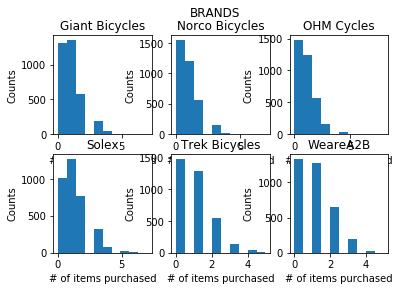

In [138]:
#Let's visualize the data
plt.close('all')
fig = plt.figure()
fig.suptitle('BRANDS')

ax1 = plt.subplot(2,3,1)
ax1.hist(data_segmentation['b_Giant Bicycles'])
ax1.set_xlabel('# of items purchased')
ax1.set_ylabel('Counts')
ax1.set_title('Giant Bicycles')

ax2 = plt.subplot(2,3,2)
ax2.hist(data_segmentation['b_Norco Bicycles'])
ax2.set_xlabel('# of items purchased')
ax2.set_ylabel('Counts')
ax2.set_title('Norco Bicycles')

ax3 = plt.subplot(2,3,3)
ax3.hist(data_segmentation['b_OHM Cycles'])
ax3.set_xlabel('# of items purchased')
ax3.set_ylabel('Counts')
ax3.set_title('OHM Cycles')

ax4 = plt.subplot(2,3,4)
ax4.hist(data_segmentation['b_Solex'])
ax4.set_xlabel('# of items purchased')
ax4.set_ylabel('Counts')
ax4.set_title('Solex')

ax5 = plt.subplot(2,3,5)
ax5.hist(data_segmentation['b_Trek Bicycles'])
ax5.set_xlabel('# of items purchased')
ax5.set_ylabel('Counts')
ax5.set_title('Trek Bicycles')

ax6 = plt.subplot(2,3,6)
ax6.hist(data_segmentation['b_WeareA2B'])
ax6.set_xlabel('# of items purchased')
ax6.set_ylabel('Counts')
ax6.set_title('WeareA2B')

Text(0.5, 1.0, 'Touring')

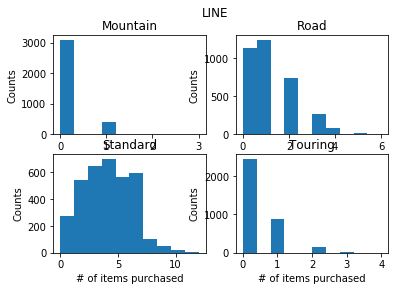

In [139]:
plt.close('all')
fig = plt.figure()
fig.suptitle('LINE')

ax1 = plt.subplot(2,2,1)
ax1.hist(data_segmentation['line_Mountain'])
ax1.set_xlabel('# of items purchased')
ax1.set_ylabel('Counts')
ax1.set_title('Mountain')

ax2 = plt.subplot(2,2,2)
ax2.hist(data_segmentation['line_Road'])
ax2.set_xlabel('# of items purchased')
ax2.set_ylabel('Counts')
ax2.set_title('Road')

ax3 = plt.subplot(2,2,3)
ax3.hist(data_segmentation['line_Standard'])
ax3.set_xlabel('# of items purchased')
ax3.set_ylabel('Counts')
ax3.set_title('Standard')

ax4 = plt.subplot(2,2,4)
ax4.hist(data_segmentation['line_Touring'])
ax4.set_xlabel('# of items purchased')
ax4.set_ylabel('Counts')
ax4.set_title('Touring')

Text(0.5, 1.0, 'size_small')

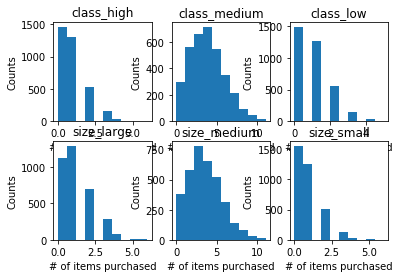

In [140]:
plt.close('all')
fig = plt.figure()
fig.suptitle('')

ax1 = plt.subplot(2,3,1)
ax1.hist(data_segmentation['class_high'])
ax1.set_xlabel('# of items purchased')
ax1.set_ylabel('Counts')
ax1.set_title('class_high')

ax2 = plt.subplot(2,3,2)
ax2.hist(data_segmentation['class_medium'])
ax2.set_xlabel('# of items purchased')
ax2.set_ylabel('Counts')
ax2.set_title('class_medium')

ax3 = plt.subplot(2,3,3)
ax3.hist(data_segmentation['class_low'])
ax3.set_xlabel('# of items purchased')
ax3.set_ylabel('Counts')
ax3.set_title('class_low')

ax4 = plt.subplot(2,3,4)
ax4.hist(data_segmentation['size_large'])
ax4.set_xlabel('# of items purchased')
ax4.set_ylabel('Counts')
ax4.set_title('size_large')

ax5 = plt.subplot(2,3,5)
ax5.hist(data_segmentation['size_medium'])
ax5.set_xlabel('# of items purchased')
ax5.set_ylabel('Counts')
ax5.set_title('size_medium')

ax6 = plt.subplot(2,3,6)
ax6.hist(data_segmentation['size_small'])
ax6.set_xlabel('# of items purchased')
ax6.set_ylabel('Counts')
ax6.set_title('size_small')

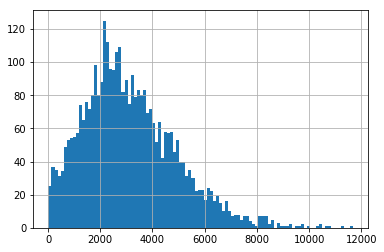

In [141]:
data_segmentation.profit.hist(bins=100)

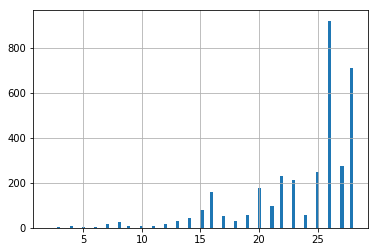

In [142]:
data_segmentation.time_since_first_sold.hist(bins=100)

In [143]:
# Matrix of Correlation
data_segmentation.corr()

,online_order,profit,time_since_first_sold,order_status,b_Giant Bicycles,b_Norco Bicycles,b_OHM Cycles,b_Solex,b_Trek Bicycles,b_WeareA2B,line_Mountain,line_Road,line_Standard,line_Touring,class_high,class_low,class_medium,size_large,size_medium,size_small
online_order,1.000000,0.003644,0.016124,-0.011081,-0.015501,0.005844,0.015390,-0.000721,0.008772,-0.001994,0.019887,0.002587,0.002715,-0.007551,0.012391,0.032670,-0.015989,-0.007261,-0.002521,0.025285
profit,0.003644,1.000000,0.243138,-0.008464,0.245054,0.144785,0.231789,0.334647,0.336866,0.416573,0.011310,0.175415,0.641066,0.345178,0.176305,0.193577,0.681210,0.539950,0.537794,0.063781
time_since_first_sold,0.016124,0.243138,1.000000,-0.016431,0.121780,0.193065,0.158464,0.169823,0.113976,0.153377,0.077976,0.180836,0.299824,0.118385,0.112960,0.112050,0.348220,0.156921,0.282193,0.193808
order_status,-0.011081,-0.008464,-0.016431,1.000000,-0.005765,-0.011626,-0.003672,-0.004150,-0.011535,-0.004175,-0.021375,-0.007062,-0.008263,-0.012960,-0.012528,-0.038806,0.004302,0.003372,-0.016799,-0.011632
b_Giant Bicycles,-0.015501,0.245054,0.121780,-0.005765,1.000000,0.010303,-0.026018,-0.002925,0.032430,-0.015019,0.007739,0.156483,0.373281,0.090650,0.254103,0.051486,0.349631,0.281182,0.252644,0.194480
b_Norco Bicycles,0.005844,0.144785,0.193065,-0.011626,0.010303,1.000000,0.015665,-0.021737,-0.008824,-0.005664,0.188715,0.286455,0.276344,-0.009335,0.210075,0.210568,0.270179,0.123452,0.278604,0.272797
b_OHM Cycles,0.015390,0.231789,0.158464,-0.003672,-0.026018,0.015665,1.000000,-0.003335,0.007914,-0.025958,0.004940,0.247738,0.301608,0.095182,0.249714,0.227120,0.246813,0.032341,0.442934,0.045983
b_Solex,-0.000721,0.334647,0.169823,-0.004150,-0.002925,-0.021737,-0.003335,1.000000,-0.032750,-0.012576,-0.042690,0.107408,0.441815,0.091757,0.145696,0.100307,0.412435,0.251820,0.365679,0.066235
b_Trek Bicycles,0.008772,0.336866,0.113976,-0.011535,0.032430,-0.008824,0.007914,-0.032750,1.000000,-0.034926,0.196048,0.269421,0.273277,-0.015461,0.108030,0.267068,0.279186,0.259610,0.228146,0.189763
b_WeareA2B,-0.001994,0.416573,0.153377,-0.004175,-0.015019,-0.005664,-0.025958,-0.012576,-0.034926,1.000000,-0.010641,0.029124,0.333134,0.285212,-0.010620,0.075654,0.409923,0.065834,0.328933,0.172553


In [144]:
#Scaling data
scaler = StandardScaler()
X = scaler.fit_transform(data_segmentation)
dataset = pd.DataFrame(X,columns=data_segmentation.columns)
dataset.head()

,online_order,profit,time_since_first_sold,order_status,b_Giant Bicycles,b_Norco Bicycles,b_OHM Cycles,b_Solex,b_Trek Bicycles,b_WeareA2B,line_Mountain,line_Road,line_Standard,line_Touring,class_high,class_low,class_medium,size_large,size_medium,size_small
0,0.192402,-0.062733,0.908906,0.200922,3.183692,1.268711,1.194174,0.718424,0.156469,-1.003793,2.553624,1.748360,1.498034,-0.599234,0.148725,1.259605,2.096610,-1.063135,2.792703,1.304322
1,-0.709039,-0.510126,-1.385182,0.200922,0.054057,-0.905244,-0.921064,-1.117314,-0.930103,1.124431,-0.351851,-1.065504,-0.538802,-0.599234,-0.933562,-0.928262,-0.496499,-1.063135,-0.379626,-0.891868
2,-1.518496,0.132038,-0.759521,0.200922,1.097269,2.355689,-0.921064,-1.117314,2.329613,-1.003793,2.553624,1.748360,-0.029593,-0.599234,0.148725,2.353538,0.022123,1.738825,-0.379626,1.304322
3,-0.000764,-1.643364,0.491799,0.200922,0.054057,-0.905244,-0.921064,-0.199445,-0.930103,-1.003793,-0.351851,-1.065504,-1.048011,-0.599234,-0.933562,-0.928262,-1.015121,-0.129148,-1.437069,-0.891868
4,-0.709039,-0.414820,0.908906,0.200922,0.054057,1.268711,-0.921064,-0.199445,0.156469,0.060319,2.553624,1.748360,-1.048011,-0.599234,0.148725,1.259605,-0.496499,0.804838,-0.908348,1.304322


## 2. Choosing the appropriate number of clusters

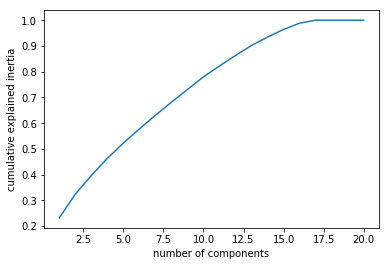

In [145]:
#Performing a PCA in order to check absence of redundancy

p = dataset.shape[1]
pca = PCA(n_components=p)
pca.fit_transform(dataset)
cumulative_explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,p+1), cumulative_explained_var)


plt.xlabel('number of components')
plt.ylabel('cumulative explained inertia');
plt.show()

In [146]:
pca.explained_variance_ratio_

array([2.31801083e-01, 9.25907401e-02, 7.20258446e-02, 6.71841480e-02,
       5.91122353e-02, 5.49492388e-02, 5.30143213e-02, 5.07138989e-02,
       4.95457683e-02, 4.90207779e-02, 4.24220960e-02, 4.06663004e-02,
       3.88950175e-02, 3.25473930e-02, 2.98136056e-02, 2.43786491e-02,
       1.13188824e-02, 7.95424956e-33, 4.89164534e-33, 1.82804277e-33])

AGGLOMERATIVE CLUSTERING

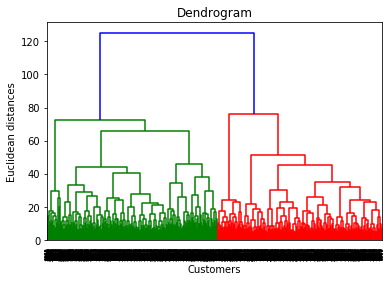

In [147]:
# Using the dendrogram to find the optimal number of clusters

X = dataset.iloc[:, :].values

import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [148]:
# Let's try 2 segments 
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc2 = hc.fit_predict(X)

data = data_segmentation.copy()
data['segment_hc2'] = y_hc2
#Summarizing data relative to every cluster
d = data[['profit','segment_hc2']].groupby('segment_hc2').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_hc2.value_counts()[i]*100/len(data) for i in range(2)],
             'Sum profit':[d[0][0], d[1][0]],   
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]))]},
             index=['clus 0','clus 1'])


,% of customers,Sum profit,% of Sum profit
clus 0,49.069568,3800708.23,35.0
clus 1,50.930432,7129306.25,65.0


In [149]:
#Fitting Hierarchical Clustering to the dataset - 3 clusters
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc3 = hc.fit_predict(X)

data = data_segmentation.copy()
data['segment_hc3'] = y_hc3
#Summarizing data relative to every cluster
d = data[['profit','segment_hc3']].groupby('segment_hc3').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_hc3.value_counts()[i]*100/len(data) for i in range(3)],
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+d[2][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+d[2][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+d[2][0]))]},
             index=['clus 0','clus 1','clus 2'])

,% of customers,% of Sum profit
clus 0,50.930432,65.0
clus 1,41.425709,29.0
clus 2,7.643859,6.0


In [150]:
# Let's try 4 segments 
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc4 = hc.fit_predict(X)

data = data_segmentation.copy()
data['segment_hc4'] = y_hc4
#Summarizing data relative to every cluster
d = data[['profit','segment_hc4']].groupby('segment_hc4').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_hc4.value_counts()[i]*100/len(data) for i in range(4)],
             'Sum profit':[d[0][0], d[1][0], d[2][0], d[3][0]],   
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                               round(100*d[3][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]))]},
             index=['clus 0','clus 1','clus 2','clus 3'])


,% of customers,Sum profit,% of Sum profit
clus 0,46.693387,6625109.80,61.0
clus 1,41.425709,3118946.09,29.0
clus 2,7.643859,681762.14,6.0
clus 3,4.237046,504196.45,5.0


In [151]:
# Let's try 5 segments 
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc5 = hc.fit_predict(X)

data = data_segmentation.copy()
data['segment_hc5'] = y_hc5
#Summarizing data relative to every cluster
d = data[['profit','segment_hc5']].groupby('segment_hc5').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_hc5.value_counts()[i]*100/len(data) for i in range(5)],
             'Sum profit':[d[0][0], d[1][0], d[2][0], d[3][0], d[4][0]],   
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0] + d[4][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                               round(100*d[3][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                               round(100*d[4][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]))]},
             index=['clus 0','clus 1','clus 2','clus 3', 'clus 4'])

,% of customers,Sum profit,% of Sum profit
clus 0,41.425709,3118946.09,29.0
clus 1,15.030060,2812987.50,26.0
clus 2,7.643859,681762.14,6.0
clus 3,4.237046,504196.45,5.0
clus 4,31.663327,3812122.30,35.0


In [152]:
# Let's try 6 segments 
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')
y_hc6 = hc.fit_predict(X)

data = data_segmentation.copy()
data['segment_hc6'] = y_hc6
#Summarizing data relative to every cluster
d = data[['profit','segment_hc6']].groupby('segment_hc6').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_hc6.value_counts()[i]*100/len(data) for i in range(6)],
             'Sum profit':[d[0][0], d[1][0], d[2][0], d[3][0], d[4][0], d[5][0]],   
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0] + d[4][0] + d[5][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]+d[5][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]+d[5][0])),
                                round(100*d[3][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]+d[5][0])),
                                round(100*d[4][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]+d[5][0])),
                                round(100*d[5][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]+d[5][0])) ]},
             index=['clus 0','clus 1','clus 2','clus 3', 'clus 4', 'clus 5'])

,% of customers,Sum profit,% of Sum profit
clus 0,15.030060,2812987.50,26.0
clus 1,34.783853,2302361.89,21.0
clus 2,7.643859,681762.14,6.0
clus 3,4.237046,504196.45,5.0
clus 4,31.663327,3812122.30,35.0
clus 5,6.641855,816584.20,7.0


K-MEANS

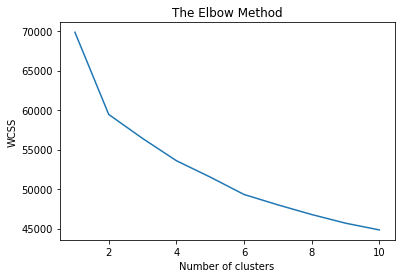

In [153]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [154]:
#Let's fit the kmeans to the data two clusters specified
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans2 = kmeans.fit_predict(X)
data = data_segmentation.copy()
data['segment_km2'] = y_kmeans2
#Summarizing data relative to every cluster
d = data[['profit','segment_km2']].groupby('segment_km2').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_km2.value_counts()[i]*100/len(data_segmentation) for i in range(2)],
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]))]},
             index=['clus 0','clus 1'])


,% of customers,% of Sum profit
clus 0,43.401088,62.0
clus 1,56.598912,38.0


In [155]:
# Let's try 3 segments 
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
data = data_segmentation.copy()
data['segment_km3'] = y_kmeans
#Summarizing data relative to every cluster
d = data[['profit','segment_km3']].groupby('segment_km3').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_km3.value_counts()[i]*100/len(data_segmentation) for i in range(3)],
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+d[2][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+d[2][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+d[2][0]))]},
             index=['clus 0','clus 1','clus 2'])

,% of customers,% of Sum profit
clus 0,39.507587,56.0
clus 1,49.957057,34.0
clus 2,10.535356,10.0


In [157]:
# Let's try 4 segments 
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans4 = kmeans.fit_predict(X)
data = data_segmentation.copy()
data['segment_km4'] = y_kmeans4
#Summarizing data relative to every cluster
d = data[['profit','segment_km4']].groupby('segment_km4').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_km4.value_counts()[i]*100/len(data_segmentation) for i in range(4)],
             'Sum profit':[d[0][0], d[1][0], d[2][0], d[3][0]], 
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0])),
                               round(100*d[3][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]))]},
             index=['clus 0','clus 1','clus 2','clus 3'])

,% of customers,Sum profit,% of Sum profit
clus 0,31.348411,1849583.70,17.0
clus 1,18.723161,3413545.31,31.0
clus 2,40.337818,4708103.56,43.0
clus 3,9.590610,958781.91,9.0


In [158]:
# Let's try 5 segments 
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans5 = kmeans.fit_predict(X)
data = data_segmentation.copy()
data['segment_km5'] = y_kmeans5
#Summarizing data relative to every cluster
d = data[['profit','segment_km5']].groupby('segment_km5').agg({'profit':'sum'}).T

pd.DataFrame({
             '% of customers':[data.segment_km5.value_counts()[i]*100/len(data) for i in range(5)],
             'Sum profit':[d[0][0], d[1][0], d[2][0], d[3][0], d[4][0]],   
             '% of Sum profit':[round(100*d[0][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0] + d[4][0])),
                                round(100*d[1][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                                round(100*d[2][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                               round(100*d[3][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0])),
                               round(100*d[4][0]/(d[0][0] + d[1][0]+ d[2][0] + d[3][0]+ d[4][0]))]},
             index=['clus 0','clus 1','clus 2','clus 3', 'clus 4'])

,% of customers,Sum profit,% of Sum profit
clus 0,16.890925,2484575.90,23.0
clus 1,30.317778,1786471.75,16.0
clus 2,14.715145,2814839.81,26.0
clus 3,9.447466,925003.15,8.0
clus 4,28.628686,2919123.87,27.0


In [ ]:
del data
del y_hc2
del y_hc3
del y_hc4
del y_hc5
del y_hc6
del y_kmeans
del y_kmeans3
del y_kmeans4

## 3. Profiling clusters

A comparison of the results of the two clustering methods, for a number of clustering varying from 2 to 4 suggests that we obtain the best results with K-Means, for a number of clusters equal to 3. As can be seen,there is a group representing 10.6% of the total mass of customers, which make 56% of the sum total of the profit in 2017. This group must be the niche we are looking for.

In [159]:
#Let's profile these customers
data_segmentation['cluster'] = y_kmeans5
data_prediction['cluster'] = y_kmeans5
data_prediction['Age'] = data_prediction['DOB'].apply(computeAge)
data_prediction = data_prediction.drop('DOB',1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [161]:
data_segmentation.groupby('cluster').agg({'count','mean','sum'}).T

cluster                                 0             1             2  \
online_order          count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    2.924845e+02  5.217002e+02  2.611826e+02   
                      mean   4.957365e-01  4.926347e-01  5.081374e-01   
profit                count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    2.484576e+06  1.786472e+06  2.814840e+06   
                      mean   4.211146e+03  1.686942e+03  5.476342e+03   
time_since_first_sold count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    1.466600e+04  2.173900e+04  1.321000e+04   
                      mean   2.485763e+01  2.052786e+01  2.570039e+01   
order_status          count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    5.869679e+02  1.052183e+03  5.087332e+02   
                      mean   9.948608e-01  9.935631e-01  9.897533e-01   
b_Giant Bicycles      count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    5.210000e+02  5.980000e+02  8.400000e+02   
                      mean   8.830508e-01  5.646837e-01  1.634241e+00   
b_Norco Bicycles      count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    3.030000e+02  4.610000e+02  7.270000e+02   
                      mean   5.135593e-01  4.353163e-01  1.414397e+00   
b_OHM Cycles          count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    3.950000e+02  5.230000e+02  7.840000e+02   
                      mean   6.694915e-01  4.938621e-01  1.525292e+00   
b_Solex               count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    9.040000e+02  7.230000e+02  9.990000e+02   
                      mean   1.532203e+00  6.827195e-01  1.943580e+00   
b_Trek Bicycles       count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    4.090000e+02  5.150000e+02  7.580000e+02   
                      mean   6.932203e-01  4.863078e-01  1.474708e+00   
b_WeareA2B            count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    9.900000e+02  5.630000e+02  7.410000e+02   
                      mean   1.677966e+00  5.316336e-01  1.441634e+00   
line_Mountain         count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    6.000000e+00  1.000000e+01  5.700000e+01   
                      mean   1.016949e-02  9.442871e-03  1.108949e-01   
line_Road             count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    4.820000e+02  7.130000e+02  9.850000e+02   
                      mean   8.169492e-01  6.732767e-01  1.916342e+00   
line_Standard         count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    2.426000e+03  2.502000e+03  3.533000e+03   
                      mean   4.111864e+00  2.362606e+00  6.873541e+00   
line_Touring          count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    6.080000e+02  1.580000e+02  2.740000e+02   
                      mean   1.030508e+00  1.491974e-01  5.330739e-01   
class_high            count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    3.290000e+02  5.310000e+02  7.760000e+02   
                      mean   5.576271e-01  5.014164e-01  1.509728e+00   
class_low             count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    3.570000e+02  4.820000e+02  6.750000e+02   
                      mean   6.050847e-01  4.551464e-01  1.313230e+00   
class_medium          count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    2.836000e+03  2.370000e+03  3.398000e+03   
                      mean   4.806780e+00  2.237960e+00  6.610895e+00   
size_large            count  5.900000e+02  1.059000e+03  5.140000e+02   
                      sum    1.029000e+03  6.460000e+02  1.016000e+03   
                      mean   1.744068e+00  6.100094e-01  1

In [ ]:
#Let's recode clusters: value 1 for the cluster we entend to target
#data = data_segmentation.copy()
#data['cluster'] = data['cluster'].replace({1:0,0:1})
#data.groupby('cluster').agg({'sum','mean'}).T

#II - Descripting the clusters

In [162]:
#Functions to be used to preocess data

def ageBracket(row):
    if row != row:
        return row
    elif row <30:
        return '<30'
    elif row <40:
        return '[30-40['
    elif row <50:
        return '[40-50['
    elif row <60:
        return '[50-60['
    else:
        return '>=60'
    
def tenureBracket(row):
    if row != row:
        return row
    elif row <5:
        return '[0-5['
    elif row <10:
        return '[5-10['
    elif row <15:
        return '[10-15['
    elif row<20:
        return '[15-20['
    else:
        return '>=20'
    
def popEvalBracket(row):
    if row != row:
        return row
    elif row <2:
        return '[0-2['
    elif row <4:
        return '[2-4['
    elif row <6:
        return '[4-6['
    elif row<8:
        return '[6-8['
    elif row<10:
        return '[8-10['
    else:
        return '>=10'
    
def purchasesBracket(row):
    if row != row:
        return row
    elif row <10:
        return '[0-10['
    elif row <20:
        return '[10-20['
    elif row <30:
        return '[20-30['
    elif row<40:
        return '[30-40['
    elif row<50:
        return '[40-50['
    elif row <60:
        return '[50-60['
    elif row <70:
        return '[60-70['
    elif row <80:
        return '[70-80['
    elif row<90:
        return '[80-90['
    else:
        return '>=90'

In [163]:
data = data_prediction.copy()
#data['cluster'] = data['cluster'].replace({1:0,0:1})

data[['past_3_years_bike_related_purchases','tenure','property_valuation','Age','cluster']].groupby('cluster').agg({'sum','mean','count'}).T

cluster                                               0             1  \
past_3_years_bike_related_purchases count    590.000000   1059.000000   
                                    sum    29611.000000  51524.000000   
                                    mean      50.188136     48.653447   
tenure                              count    575.000000   1034.000000   
                                    sum     6322.000000  10998.000000   
                                    mean      10.994783     10.636364   
property_valuation                  count    590.000000   1059.000000   
                                    sum     4333.000000   8007.000000   
                                    mean       7.344068      7.560907   
Age                                 count    575.000000   1034.000000   
                                    sum    24497.000000  42339.000000   
                                    mean      42.603478     40.946809   

cluster                                               2             3  \
past_3_years_bike_related_purchases count    514.000000    330.000000   
                                    sum    24399.000000  16114.000000   
                                    mean      47.468872     48.830303   
tenure                              count    498.000000    325.000000   
                                    sum     5294.000000   3400.000000   
                                    mean      10.630522     10.461538   
property_valuation                  count    513.000000    327.000000   
                                    sum     3833.000000   2403.000000   
                                    mean       7.471735      7.348624   
Age                                 count    498.000000    325.000000   
                                    sum    20384.000000  13188.000000   
                                    mean      40.931727     40.578462   

cluster                                               4  
past_3_years_bike_related_purchases count   1000.000000  
                                    sum    48833.000000  
                                    mean      48.833000  
tenure                              count    985.000000  
                                    sum    10488.000000  
                                    mean      10.647716  
property_valuation                  count   1000.000000  
                                    sum     7647.000000  
                                    mean       7.647000  
Age                                 count    985.000000  
                                    sum    41417.000000  
                                    mean      42.047716

In [175]:
state = data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

cluster = data['cluster']

tab = pd.crosstab(state,cluster)
tab

cluster,0,1,2,3,4
state,,,,,
NSW,302,572,277,170,545
QLD,130,222,109,65,217
VIC,158,265,127,92,238


# III - Predictions

In [ ]:
data = data_prediction.copy()
data['cluster'] = data['cluster'].replace({1:0,2:1,3:0})
#y = data.pop('cluster')
#X = data
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=693,random_state=42)

In [ ]:
data

In [ ]:
#Jobs' groups
Managers = ['Account Coordinator','Account Executive','Account Representative I','Account Representative II',
            'Account Representative III','Account Representative IV','Administrative Officer','Analog Circuit Design manager',
            'Assistant Manager','Assistant Media Planner','Director of Sales','General Manager','Media Manager I',
            'Media Manager II','Media Manager III','Media Manager IV','Marketing Manager','Human Resources Manager',
            'Information Systems Manager','Project Manager','Recruiter','Recruiting Manager',
            'Payment Adjustment Coordinator','VP Accounting','VP Marketing','VP Product Management',
            'VP Quality Control','VP Sales','Senior Sales Associate','Sales Associate','Sales Representative']

Professionals = ['Accountant I','Accountant II', 'Accountant III','Accountant IV','Actuary','Analyst Programmer',
                 'Assistant Professor','Associate Professor','Automation Specialist I','Automation Specialist II',
                 'Automation Specialist III','Automation Specialist IV','Biostatistician I','Biostatistician II',
                 'Biostatistician III','Biostatistician IV','Budget/Accounting Analyst I','Budget/Accounting Analyst II',
                 'Budget/Accounting Analyst III','Budget/Accounting Analyst IV','Business Systems Development Analyst',
                 'Chemical Engineer', 'Chief Design Engineer','Civil Engineer','Clinical Specialist','Community Outreach Specialist',
                 'Compensation Analyst','Computer Systems Analyst I','Computer Systems Analyst II','Computer Systems Analyst III', 
                 'Computer Systems Analyst IV','Cost Accountant','Data Coordiator','Database Administrator I', 'Database Administrator II',
                 'Database Administrator III', 'Database Administrator IV','Dental Hygienist','Design Engineer',
                 'Developer I','Developer II','Developer III','Developer IV', 'Editor','Electrical Engineer','Engineer I','Engineer II',
                 'Engineer III','Engineer IV','Environmental Specialist','Geological Engineer','Geologist I','Geologist II','Geologist III',
                 'Geologist IV','GIS Technical Architect','Graphic Designer','Health Coach I','Health Coach II','Health Coach III',
                 'Health Coach IV','Web Designer I','Web Designer II','Web Designer III','Web Designer IV','Web Developer I','Web Developer II',
                 'Web Developer III','Web Developer IV','Statistician I','Statistician II', 'Statistician III','Statistician IV',
                 'Structural Analysis Engineer','Structural Engineer','Systems Administrator I','Systems Administrator II','Systems Administrator III',
                 'Systems Administrator IV','Pharmacist','Mechanical Systems Engineer','Nuclear Power Engineer','Nurse','Nurse Practicioner',
                 'Occupational Therapist','Physical Therapy Assistant','Product Engineer','Professor','Programmer Analyst I','Programmer Analyst II',
                 'Programmer Analyst III','Programmer Analyst IV','Programmer I','Programmer II','Programmer III','Programmer IV','Quality Control Specialist',
                 'Quality Engineer','Software Consultant','Software Engineer I','Software Engineer II','Software Engineer III','Software Engineer IV','Software Test Engineer I',
                 'Software Test Engineer II','Software Test Engineer III','Software Test Engineer IV','Speech Pathologist','Teacher','Social Worker', 'Senior Developer',
                 'Senior Editor','Senior Financial Analyst','Senior Quality Engineer','Financial Analyst','Food Chemist','Financial Advisor','Registered Nurse',
                 'Senior Cost Accountant','Staff Accountant I','Staff Accountant II','Staff Accountant III','Staff Accountant IV','Staff Scientist','Tax Accountant',
                 'Technical Writer','Research Nurse','Research Assistant I','Research Assistant II','Research Assistant III','Research Assistant IV',
                 'Research Associate','Librarian','Internal Auditor', 'Junior Executive']

Paraprofessionals = ['Environmental Tech','Help Desk Operator','Help Desk Technician','Desktop Support Technician',
                     'Safety Technician I','Safety Technician II','Safety Technician III','Safety Technician IV','Paralegal',
                     'Operator']

Salespersons_service_workers = ['Administrative Assistant I','Administrative Assistant II','Administrative Assistant III','Administrative Assistant IV','Executive Secretary','Accounting Assistant I','Accounting Assistant II','Accounting Assistant III','Accounting Assistant IV','Human Resources Assistant I','Human Resources Assistant II','Human Resources Assistant III','Human Resources Assistant IV','Office Assistant I','Office Assistant II','Office Assistant III','Office Assistant IV','Marketing Assistant','Legal Assistant']

In [ ]:
#Let's define classes we are going to use to process the data 

class NullCreator(BaseEstimator,TransformerMixin): #2nd
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X['tenure_nan'] = X['tenure'].isnull()
        X['property_valuation_nan'] = X['property_valuation'].isnull()
        X['Age_nan'] = X['Age'].isnull()
        
        X['job_title_nan'] = X['job_title'].isnull()
        X['job_industry_category_nan'] = X['job_industry_category'].isnull()
        X['state_nan'] = X['state'].isnull()
        
        return X

class ColumnSelection(BaseEstimator,TransformerMixin): #3rd
    def __init__(self,columns):
        self.columns = columns
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return pd.DataFrame(X, columns=self.columns)

In [ ]:
#Let's define classes we are going to use to process the data

cat = ['job_title','job_industry_category','state','gender','gender_U','wealth_segment','owns_car','tenure_nan',
       'property_valuation_nan','Age_nan','job_title_nan','job_industry_category_nan','state_nan']
num = ['past_3_years_bike_related_purchases','Age','tenure','property_valuation']

class ProcessCategorical(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        X['job_group'] = X['job_title']
        X['job_group'] = X['job_group'].replace(to_replace=Managers, value='Managers')
        X['job_group'] = X['job_group'].replace(to_replace=Professionals, value='Professionals')
        X['job_group'] = X['job_group'].replace(to_replace=Paraprofessionals, value='Paraprofessionals')
        X['job_group'] = X['job_group'].replace(to_replace=Salespersons_service_workers, value='Salespersons_service_workers')
        X.pop('job_title')
        
        X['state'] = X['state'].replace({'Victoria':'VIC','New South Wales':'NSW'})
        
        return X
    
    
    
class Encoder(BaseEstimator,TransformerMixin):
    "One hot encodes categorical variable"
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        Xt = pd.DataFrame(X)
        Xt.to_csv('categorical.csv')
        return pd.get_dummies(data=Xt, dummy_na=True,drop_first=True)
    
class DfTransformer(BaseEstimator,TransformerMixin):
    "Given a data set (array for instance), transforms this data set onto a pandas dataframe"
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        if not isinstance(X,pd.DataFrame):
            return pd.DataFrame(X)
        else:
            return X
    
class SafeGuard(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        pd.DataFrame(X).to_csv('numerical.csv')
        return pd.DataFrame(X)

In [ ]:
#let's design a pipeline

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
pca = PCA(n_components=19)

cat_pipe = Pipeline([('cs',ColumnSelection(cat)), ('pc',ProcessCategorical()), ('ci',cat_imputer),('enc',Encoder()),
                     ('pca',pca), ('dt',DfTransformer())
                    ])

num_pipe = Pipeline([('cs',ColumnSelection(num)), ('ni',num_imputer), ('sg',SafeGuard()), ('sc',scaler), ('dt',DfTransformer())])

union = FeatureUnion([('cp',cat_pipe),('np',num_pipe) ])


In [ ]:
#The models to be used
logreg = LogisticRegression()
KNN = KNeighborsClassifier()
RF = RandomForestClassifier(n_estimators = 240, criterion = 'gini', random_state = 0)
SVM = SVC(kernel = 'linear', random_state = 0,probability = True, C=1)
xgbc = XGBClassifier(max_depth=1,n_estimators=200,learning_rate=0.06)
abc = AdaBoostClassifier(learning_rate=0.4, n_estimators= 3)
mlpc = MLPClassifier(hidden_layer_sizes = (5,5),activation='relu', solver='adam',max_iter=300)
sgdc = SGDClassifier(alpha= 0.016681005372000592, learning_rate='optimal', loss='log', max_iter=50, penalty='elasticnet')

pipe = Pipeline([
                 ('nc',NullCreator()), ('union',union),('model',KNN)])    
    
    
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           
                           cv = 10,
                           n_jobs = -1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
#grid_search.best_params_
KNN.get_params().keys()

In [ ]:
pd.DataFrame(X_train,columns=[])

In [ ]:
list(range(5,100,15))

In [ ]:
mca_imputer = SimpleImputer(strategy='most_frequent')

data_MCA = data_prediction.copy()
data_MCA['Age'] = data_MCA['DOB'].apply(computeAge)
data_MCA['state'] = data_MCA['state'].replace({'Victoria':'VIC','New South Wales':'NSW'})
data_MCA['job_group'] = data_MCA['job_title']
data_MCA['job_group'] = data_MCA['job_group'].replace(to_replace=Managers, value='Managers')
data_MCA['job_group'] = data_MCA['job_group'].replace(to_replace=Professionals, value='Professionals')
data_MCA['job_group'] = data_MCA['job_group'].replace(to_replace=Paraprofessionals, value='Paraprofessionals')
data_MCA['job_group'] = data_MCA['job_group'].replace(to_replace=Salespersons_service_workers, value='Salespersons_service_workers')
data_MCA = data_MCA[['gender','past_3_years_bike_related_purchases','Age','job_group','job_industry_category',
                     'wealth_segment','owns_car','tenure','state','property_valuation','segment']]

data_MCA['Age'] = data_MCA['Age'].apply(ageBracket)
data_MCA['tenure'] = data_MCA['tenure'].apply(tenureBracket)
data_MCA['property_valuation'] = data_MCA['property_valuation'].apply(popEvalBracket)
data_MCA['past_3_years_bike_related_purchases'] = data_MCA['past_3_years_bike_related_purchases'].apply(purchasesBracket)
data_MCA['segment'] = data_MCA['segment'].replace({0:'clust_0', 1:'clust_1', 2:'clust_2'})

cols = list(data_MCA.columns)
data_MCA = mca_imputer.fit_transform(data_MCA)
data_MCA = pd.DataFrame(data_MCA,columns=cols)

data_MCA.to_csv('data_MCA.csv', index=False)